In [ ]:
features_selected = ['department', 'region', 'awards_won?', 
                     'previous_year_rating', 'KPIs_met >80%',
                      'avg_training_score', 'total_score', 'pca_combined']
                      

In [ ]:
features_selected_categorical = ['department', 'region', 'awards_won?','KPIs_met >80%']
features_selected_ordinal = ['previous_year_rating']
features_selected_numerical = ['avg_training_score', 'total_score', 'pca_combined']

In [ ]:
# Save to disk
# # X.loc[:, features_selected] -> to store only selected features
# X.to_csv(path_or_buf='/content/drive/My Drive/Colab Notebooks/data/HR_processed.csv', index=False)
# pd.DataFrame(data=train_index,columns=['train_index']).to_csv(
#     path_or_buf='/content/drive/My Drive/Colab Notebooks/data/HR_train_index.csv',
#     index=False)
# pd.DataFrame(data=validate_index,columns=['validate_index']).to_csv(
#     path_or_buf='/content/drive/My Drive/Colab Notebooks/data/HR_validate_index.csv',
#     index=False)

# Utility Methods for Modelling

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, 
                          title=None, for_data='train'):
    '''
    for_data = Train or CV or Test
    '''
    
    if not title:
        title = 'Confusion Matrix'
    
    cm = confusion_matrix(y_true, y_pred)

    # Fliping is needed, because originally
    # True/Actual labels are on Y-Axis and 
    # Predicted labels are on X-Axis, 
    # but we need Predicted labels on Y-Axis
    # flip horizontally: axis = 1
    cm = np.flip(np.flip(cm, 0),1) #changed
    
    # Since we have flipped Actual & Predicted
    # We need to flip the class Labels aswell
    # the labels are in Lexicographical order in
    # data. Hence 0(Rejected) followed by 1(Accepted).
    classes = np.flip(classes)
    
    #classes = classes[unique_labels(y_true, y_pred)]

    if for_data.lower().strip() == 'test':
        cmap = plt.cm.Oranges
    else:
        cmap = plt.cm.Blues

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    
    #ax.figure.colorbar(im, ax=ax) # Equivalent to 'cbar' in sns.heatmap()
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[0]),# [1]
           yticks=np.arange(cm.shape[1]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Predicted label',
           xlabel='True label')# changed
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[1]):
        for j in range(cm.shape[0]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    plt.show()
    


In [ ]:
def stratified_sample(y, sample_size):
    '''
        Parameters :
        ---------------------------------------
        y : Target label

        sample_size : Integer or Float value indicating 
                      number of samples to be drawn

        Return:
        --------------------------------
        list of index of samples drawn
    '''

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    # check if sample size or sample fraction provided
    # numbers.Integral --> needed in case of Long integers
    if isinstance(sample_size, int):
        if sample_size > len(y):
            raise ValueError('sample_size should be less than or equal to length of y.')
    elif isinstance(sample_size, float):
        sample_size = math.ceil(len(y) * sample_size)
        int_flag = False
    else:
        raise ValueError('sample_size can only be integer or float')

    # no of instances of each label
    vc = y.value_counts()
    
    # count fraction of each label in original data
    vc = vc / len(y)
    
    # holds the index of the subsample drawn
    # this wil be returned
    sub_sample_index = []

    for label in vc.index:
        # calculate no of samples for each class to be returned
        count = math.ceil(sample_size * vc[label])

        # draw the sample (index)
        # list() => index data is not supported by random.sample()
        sub_sample = random.sample(list(y[y==label].index), count) 

        sub_sample_index.extend(sub_sample)

    
    return sub_sample_index


In [ ]:
   
def tuned_model(tuned_base_model, X, y):

    tuned_base_model = tuned_base_model.fit(X, y)

    calibrated_model = CalibratedClassifierCV(base_estimator=tuned_base_model, cv='prefit')
    calibrated_model = calibrated_model.fit(X, y)

    return tuned_base_model, calibrated_model

# One - hot Encoded data

In [ ]:
# load from disk

X = pd.read_csv(filepath_or_buffer='/content/drive/My Drive/Colab Notebooks/data/HR_processed.csv')

train_index = pd.read_csv(filepath_or_buffer='/content/drive/My Drive/Colab Notebooks/data/HR_train_index.csv')
validate_index = pd.read_csv(filepath_or_buffer='/content/drive/My Drive/Colab Notebooks/data/HR_validate_index.csv')

In [ ]:
# get train_index and validate_index ready to use
# while loading from drive gets loaded as pd.Series
train_index = train_index.values.flatten()
validate_index = validate_index.values.flatten()

In [ ]:
# X = X.drop(['employee_id'], axis='columns')

In [ ]:
oneHot_encoder = OneHotEncoder(handle_unknown='ignore')

oneHot_encoder = oneHot_encoder.fit(X.loc[train_index,
                                features_selected_categorical
                                ]
                            )

In [ ]:
X_oneHot = oneHot_encoder.transform(X.loc[:, features_selected_categorical])

In [ ]:
one_hot_cat_feat_labels = []

for i in range(0,len(oneHot_encoder.categories_)):
    #one_hot_cat_feat_labels.extend(oneHot_encoder.categories_[i])
    one_hot_cat_feat_labels.extend([features_selected_categorical[i]+ '_'+ 
                                    str(x) for x in oneHot_encoder.categories_[i]]
                                  )

In [ ]:
X_oneHot = pd.DataFrame(data=X_oneHot.toarray(), columns=one_hot_cat_feat_labels)

In [ ]:
X_oneHot = pd.concat(objs=[X_oneHot, X.loc[:, features_selected_ordinal + features_selected_numerical]]
          ,axis=1)

## TSNE

In [ ]:
def perform_tsne(X, n_components=2):
    '''
        This function performs tSNE on the Data (X) provided.
    '''
    tsne = TSNE(n_components=n_components, random_state=8)

    if isinstance(X, pd.DataFrame):
        X_embedding = tsne.fit_transform(X)
    else:
        # if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray())
        # .toarray() will convert the sparse matrix into dense matrix
        X_embedding = tsne.fit_transform(X.toarray())
    
    # return data with reduced dimensions
    return X_embedding


def plot_tsne(X_embedding, y, title):
    
    # hstack expects 2-D array
    # hence use of reshape(-1,1)
    tsne_data = np.hstack((X_embedding, np.array(y).reshape(-1,1)))
    tsne_df = pd.DataFrame(data=tsne_data, columns=['Dimension_x','Dimension_y','Label']) #Target = Score
        
    #fig, ax = plt.subplots(1, 1, figsize=(6,6))
    
    plot = sns.pairplot(x_vars=["Dimension_x"], y_vars=["Dimension_y"],
                        data=tsne_df, hue="Label", palette={0:'r', 1:'b'},
                        height=5, plot_kws={'alpha':0.6})
    # plot.fig.suptitle(title)
    
    plt.title(title)
    plt.show()

In [ ]:
# tsne_index = stratified_sample(X.is_promoted, 10000)

In [ ]:
# embedded_X = perform_tsne(X_oneHot.loc[tsne_index, :])
embedded_X = perform_tsne(X_oneHot.loc[train_index.values.flatten(), :])

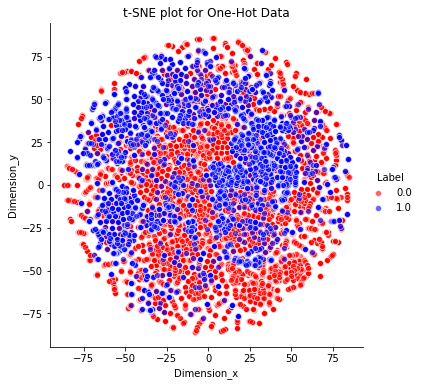

In [ ]:
plot_tsne(embedded_X, X.is_promoted[train_index.values.flatten()], 't-SNE plot for One-Hot Data')

In [ ]:
import plotly.express as px

In [ ]:
# embedded_3D = perform_tsne(X_oneHot.loc[tsne_index, :], n_components=3)
embedded_3D = perform_tsne(X_oneHot.loc[train_index.values.flatten(), :], n_components=3)

In [ ]:
fig = px.scatter_3d(np.column_stack([embedded_3D, X.is_promoted[tsne_index]]),
                    x=0, y=1, z=2, color=3, opacity=0.7, color_continuous_scale='bluered')

fig.update_layout(title="tSNE 3D for One Hot data")

fig.show()

# Logistic Regression

### Hyper parameter Tuning

In [ ]:
param_grid = {'alpha' : [10**x for x in range(-5,3)]}
performance_metric = {'F1': 'f1', 'Accuracy': 'accuracy'}

In [ ]:

gs  = GridSearchCV(SGDClassifier(loss='log', penalty='l2', random_state=1),
                   param_grid, scoring=performance_metric,
                   refit='F1', return_train_score=True
        ) 
 

In [ ]:
gs.fit(X_oneHot.loc[train_index.values.flatten(),:], y[train_index.values.flatten()])

GridSearchCV(cv=None, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='log', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5, random_state=1,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                                   100]},
             pre_dispatch='2*n_jobs', refit='F1', return_train_score=True,
             scorin

In [ ]:
results = gs.cv_results_
results = pd.DataFrame(results)
#results

In [ ]:
print('Data for Max F1 score')
print('-'*50)
results[results.mean_test_F1 == results.mean_test_F1.max()]

Data for Max F1 score
--------------------------------------------------


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_F1,split1_test_F1,split2_test_F1,split3_test_F1,split4_test_F1,mean_test_F1,std_test_F1,rank_test_F1,split0_train_F1,split1_train_F1,split2_train_F1,split3_train_F1,split4_train_F1,mean_train_F1,std_train_F1,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,split4_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_train_Accuracy,split1_train_Accuracy,split2_train_Accuracy,split3_train_Accuracy,split4_train_Accuracy,mean_train_Accuracy,std_train_Accuracy
1,0.267417,0.007084,0.007694,0.000169,0.0001,{'alpha': 0.0001},0.357741,0.329004,0.306843,0.375879,0.351832,0.34426,0.023965,1,0.352072,0.330003,0.332246,0.383215,0.351287,0.349764,0.0191,0.929989,0.929296,0.928384,0.929182,0.92941,0.929252,0.000515,1,0.930009,0.92927,0.929983,0.930439,0.930296,0.929999,0.000403


In [ ]:
print('Data for Max Accuracy')
print('-'*50)
results[results.mean_test_Accuracy == results.mean_test_Accuracy.max()]

Data for Max Accuracy
--------------------------------------------------


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_F1,split1_test_F1,split2_test_F1,split3_test_F1,split4_test_F1,mean_test_F1,std_test_F1,rank_test_F1,split0_train_F1,split1_train_F1,split2_train_F1,split3_train_F1,split4_train_F1,mean_train_F1,std_train_F1,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,split4_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_train_Accuracy,split1_train_Accuracy,split2_train_Accuracy,split3_train_Accuracy,split4_train_Accuracy,mean_train_Accuracy,std_train_Accuracy
1,0.267417,0.007084,0.007694,0.000169,0.0001,{'alpha': 0.0001},0.357741,0.329004,0.306843,0.375879,0.351832,0.34426,0.023965,1,0.352072,0.330003,0.332246,0.383215,0.351287,0.349764,0.0191,0.929989,0.929296,0.928384,0.929182,0.92941,0.929252,0.000515,1,0.930009,0.92927,0.929983,0.930439,0.930296,0.929999,0.000403


#### Plot tuning results

In [ ]:
f1_train = np.array(results['mean_train_F1'], dtype=np.float)
f1_test = np.array(results['mean_test_F1'], dtype=np.float)

accuracy_train = np.array(results['mean_train_Accuracy'], dtype=np.float)
accuracy_test = np.array(results['mean_test_Accuracy'], dtype=np.float)

In [ ]:
alphas = np.array(results['param_alpha'], dtype=np.float)

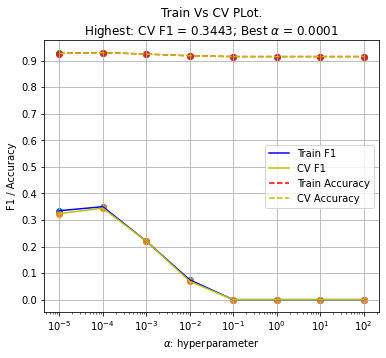

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        
plt.plot(alphas, f1_train, '-', color = 'b', label='Train F1')
plt.plot(alphas, f1_test, '-', color= 'y', label='CV F1')

plt.scatter(alphas, f1_train)
plt.scatter(alphas, f1_test)

# Accuracy 
plt.plot(alphas, accuracy_train, '--', color='r', label='Train Accuracy')
plt.plot(alphas, accuracy_test, '--', color='y', label='CV Accuracy')

plt.scatter(alphas, accuracy_train)
plt.scatter(alphas, accuracy_test)



plt.legend()

# Take log as the X - axis value
plt.xscale(value='log')

plt.xlabel(r"$\alpha$: hyperparameter")
plt.ylabel("F1 / Accuracy")
plt.yticks(np.arange(0,1,.1))

alpha_sign = r'$\alpha$'
plt.title(f"Train Vs CV PLot.\nHighest: CV F1 = {np.max(f1_test).round(4)}; Best {alpha_sign} = {alphas[np.argmax(f1_test)]}")

plt.grid()

plt.show()

In [ ]:
print('Best parameter:')
print('-'*50)
best_alpha = gs.best_params_['alpha']
print(gs.best_params_)

Best parameter:
--------------------------------------------------
{'alpha': 0.0001}


In [ ]:
gs.best

### Tuned Model

In [ ]:
LR_tuned = SGDClassifier(loss='log', alpha=0.00001, random_state=1)
LR_tuned = LR_tuned.fit(X_oneHot.loc[train_index.values.flatten(),:], y[train_index.values.flatten()])

In [ ]:
# calibrate the LR model
LR_calibarted = CalibratedClassifierCV(base_estimator=LR_tuned, cv='prefit')
LR_calibarted = LR_calibarted.fit(X_oneHot.loc[train_index.values.flatten(),:], y[train_index.values.flatten()])

In [ ]:
LR_tuned, LR_calibarted= tuned_model(SGDClassifier(loss='log', alpha=best_alpha, random_state=1),
                                    X_oneHot.loc[train_index.values.flatten(),:],
                                    y[train_index.values.flatten()]
                                )

In [ ]:
y_pred = LR_calibarted.predict(X_oneHot.loc[validate_index.values.flatten(),:])

In [ ]:
# seperate val data
print('F1:',f1_score(y[validate_index.values.flatten()],
         y_pred))
print('Accuracy:', accuracy_score(y[validate_index.values.flatten()],
         y_pred))

F1: 0.3648535564853556
Accuracy: 0.9307608100711549


#### Confusion Matrix


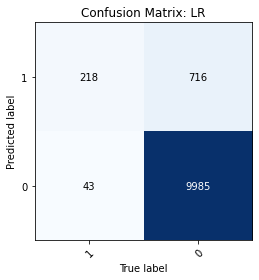

In [ ]:
plot_confusion_matrix(y[validate_index.values.flatten()], y_pred, LR_calibarted.classes_, title='Confusion Matrix: LR')

#### Feature Importance

In [ ]:
print('Features in Descending order of Importance')
print('-'*50)

pd.DataFrame(np.column_stack([X_oneHot.columns[np.argsort(LR_tuned.coef_[0])[::-1]],
                              LR_tuned.coef_[0][np.argsort(LR_tuned.coef_[0])[::-1]].round(6)
                            ]),
             columns = ['Features', 'Importance']
            )

Features in Descending order of Importance
--------------------------------------------------


,Features,Importance
0,department_Sales & Marketing,4.37845
1,department_HR,3.76664
2,avg_training_score,3.37575
3,department_Operations,1.19155
4,department_Finance,1.15474
5,KPIs_met >80%_1,1.15199
6,awards_won?_1,1.03677
7,previous_year_rating,0.757141
8,department_Legal,0.722193
9,region_region_4,0.549795


Observation
- Best alpha = 0.00001;
    - F1: 0.3649
    - Accuracy: 0.93076


# Decision Tree

Since, we training the decision tree by using 5 - fold CV on the training data. This model behaves like a Bagged Tree classifier.

### Hyperparameter Tuning

In [ ]:
min_samples = [2,3,5,7,9, 15, 21]
min_samples.extend([i for i in range(25,501,25)])

param_grid = {'max_depth': np.arange(2,11), 'min_samples_split': min_samples}
performance_metric = {'F1': 'f1', 'Accuracy': 'accuracy'}

In [ ]:
gs = GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced', random_state=1),
                  param_grid=param_grid, scoring=performance_metric,
                  refit='F1', return_train_score=True)

### return_train_score = False(default) --> No use for DT, can be used in Logistic like models to plot train vs Cv plot

In [ ]:
gs.fit(X_oneHot.loc[train_index.values.flatten(),:], y[train_index.values.flatten()])

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=1, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,

In [ ]:
results = gs.cv_results_
results = pd.DataFrame(results)
#results

In [ ]:
results[results.mean_test_F1 == results.mean_test_F1.max()]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_F1,split1_test_F1,split2_test_F1,split3_test_F1,split4_test_F1,mean_test_F1,std_test_F1,rank_test_F1,split0_train_F1,split1_train_F1,split2_train_F1,split3_train_F1,split4_train_F1,mean_train_F1,std_train_F1,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,split4_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_train_Accuracy,split1_train_Accuracy,split2_train_Accuracy,split3_train_Accuracy,split4_train_Accuracy,mean_train_Accuracy,std_train_Accuracy
218,0.122617,0.003138,0.007051,0.000135,10,5,"{'max_depth': 10, 'min_samples_split': 5}",0.357009,0.348353,0.360022,0.361685,0.362402,0.357894,0.005119,1,0.378735,0.37193,0.378227,0.377857,0.374326,0.376215,0.002647,0.726454,0.717984,0.73201,0.735546,0.732353,0.728869,0.006179,1,0.739794,0.729538,0.741112,0.740799,0.735439,0.737336,0.004398


In [ ]:
results[results.mean_test_Accuracy == results.mean_test_Accuracy.max()]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_F1,split1_test_F1,split2_test_F1,split3_test_F1,split4_test_F1,mean_test_F1,std_test_F1,rank_test_F1,split0_train_F1,split1_train_F1,split2_train_F1,split3_train_F1,split4_train_F1,mean_train_F1,std_train_F1,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,split4_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_train_Accuracy,split1_train_Accuracy,split2_train_Accuracy,split3_train_Accuracy,split4_train_Accuracy,mean_train_Accuracy,std_train_Accuracy
218,0.122617,0.003138,0.007051,0.000135,10,5,"{'max_depth': 10, 'min_samples_split': 5}",0.357009,0.348353,0.360022,0.361685,0.362402,0.357894,0.005119,1,0.378735,0.37193,0.378227,0.377857,0.374326,0.376215,0.002647,0.726454,0.717984,0.73201,0.735546,0.732353,0.728869,0.006179,1,0.739794,0.729538,0.741112,0.740799,0.735439,0.737336,0.004398


#### Plot tuning results

In [ ]:
################# Data needed for plotting #################### 
max_depths = results['param_max_depth']
min_samples = results['param_min_samples_split']
f1_scores_train = results['mean_train_F1']
f1_scores_test = results['mean_test_F1']


############ Data Frame for Seaborn Heatmap ########

f1_train_df = pd.DataFrame(data=np.column_stack([max_depths, min_samples,
                                                  f1_scores_train]
                                         ),
                            columns=['max_depth', 'min_samples', 'F1'], 
                            dtype=np.float  
                    )
# Pivot is needed for Seaborn Heatmap
f1_train_df = f1_train_df.pivot('max_depth', 'min_samples', 'F1')


f1_test_df = pd.DataFrame(data=np.column_stack([max_depths, min_samples,
                                                  f1_scores_test]
                                                 ),
                               columns=['max_depth', 'min_samples', 'F1'],
                            dtype = np.float
                        )
# Pivot is needed for Seaborn Heatmap
f1_test_df = f1_test_df.pivot('max_depth', 'min_samples', 'F1')

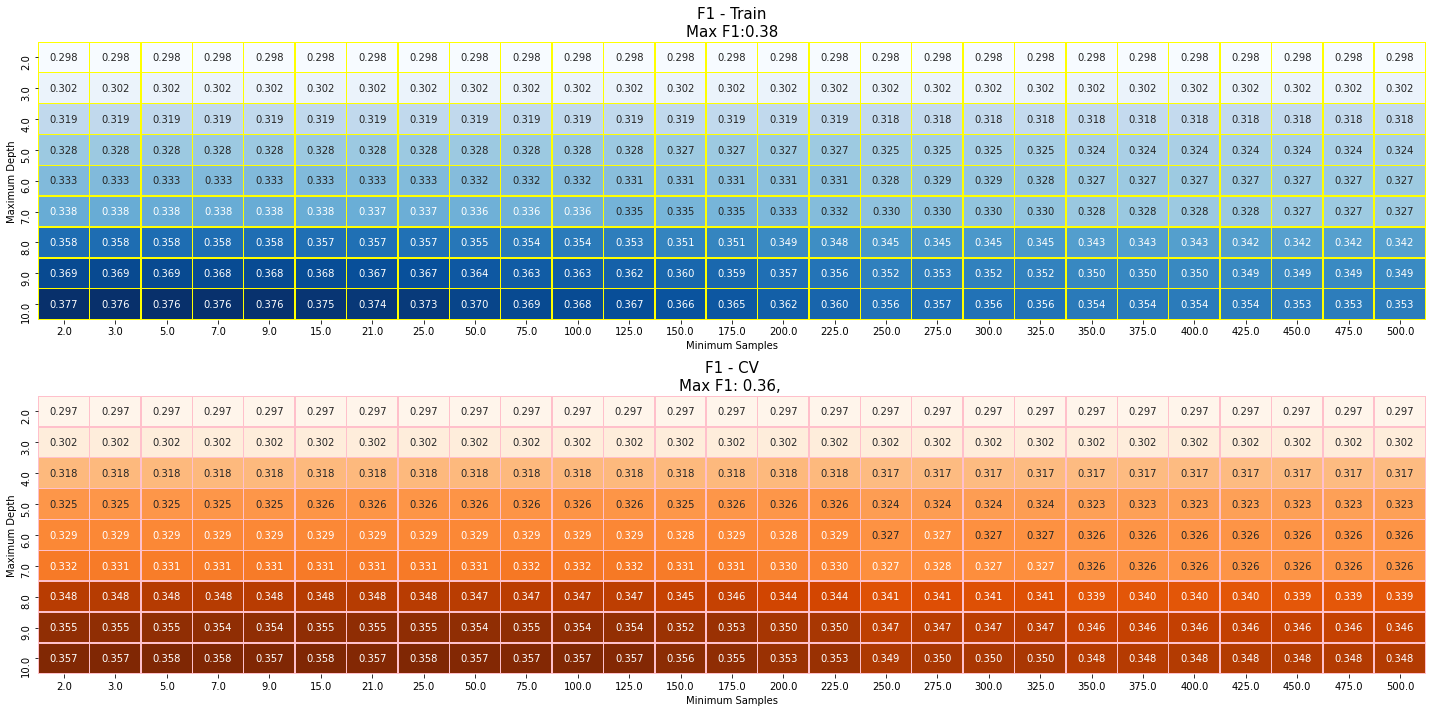

In [ ]:
########## PLOTS ##########

xlabel = 'Minimum Samples'
ylabel = 'Maximum Depth'

fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(20, 10))

#plt.subplot(ax[0])
axs = ax[0]
sns.heatmap(f1_train_df, annot=True, linewidths=0.5, cmap = plt.cm.Blues,
            linecolor='yellow', fmt='0.3f', cbar=False, ax=axs)
axs.set_title(f'F1 - Train\nMax F1:{max(f1_scores_train):.2f}', fontsize=15)
axs.set_xlabel(xlabel)
axs.set_ylabel(ylabel)

axs = ax[1]
sns.heatmap(f1_test_df, annot=True, linewidths=0.5, cmap = plt.cm.Oranges,
            linecolor='pink', fmt='0.3f', cbar=False, ax=axs)
axs.set_title(f'F1 - CV\nMax F1: {max(f1_scores_test):.2f}, ', fontsize=15)
axs.set_xlabel(xlabel)
axs.set_ylabel(ylabel)

plt.tight_layout(h_pad=1)
plt.show()

In [ ]:
print('Best combination of Parameters')
print('-'*50)

for k, v in gs.best_params_.items():
    print(k,':',v)

Best combination of Parameters
--------------------------------------------------
max_depth : 10
min_samples_split : 5


### Tuned Model

Although best min_samples_split = 5, but we will take $\text{min_samples_split}=25$ at same tree depth$(10)$, because it gives us better bias variance trade-off.

In [ ]:
# Tuned Decision Tree
tuned_DT = DecisionTreeClassifier(max_depth=10, min_samples_split=25, class_weight='balanced', random_state=1)
tuned_DT = tuned_DT.fit(X_oneHot.loc[train_index.values.flatten(),:], y[train_index.values.flatten()])

In [ ]:
# calibrate the DT model
DT_calibarted = CalibratedClassifierCV(base_estimator=tuned_DT, cv='prefit')
DT_calibarted = DT_calibarted.fit(X_oneHot.loc[train_index.values.flatten(),:], y[train_index.values.flatten()])

In [ ]:
y_pred = DT_calibarted.predict(X_oneHot.loc[validate_index.values.flatten(),:])

In [ ]:
# seperate val data
print('F1:',f1_score(y[validate_index.values.flatten()],
         y_pred))
print('Accuracy:', accuracy_score(y[validate_index.values.flatten()],
         y_pred))

F1: 0.5046197583511016
Accuracy: 0.9364167122787812


##### Confusion Matrix

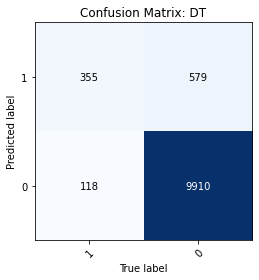

In [ ]:
plot_confusion_matrix(y[validate_index.values.flatten()], y_pred, DT_calibarted.classes_, title='Confusion Matrix: DT')#.plot()

#### Feature Importance

In [ ]:
print('Features in Descending order of Importance')
print('-'*50)

pd.DataFrame(np.column_stack([X_oneHot.columns[np.argsort(tuned_DT.feature_importances_)[::-1]],
                              tuned_DT.feature_importances_[np.argsort(tuned_DT.feature_importances_)[::-1]].round(6)
                            ]),
             columns = ['Features', 'Importance']
            )

Features in Descending order of Importance
--------------------------------------------------


,Features,Importance
0,KPIs_met >80%_0,0.274537
1,pca_combined,0.226601
2,avg_training_score,0.188518
3,department_Sales & Marketing,0.115803
4,awards_won?_0,0.048571
5,department_Operations,0.047484
6,department_HR,0.020332
7,department_Finance,0.017639
8,department_Procurement,0.015934
9,department_Analytics,0.011415


### Tree plot

In [ ]:
from sklearn import tree

In [ ]:
plt.figure(figsize=(30,25))
tree.plot_tree(tuned_DT)
plt.show()

### Observation

- Decision Tree model is not overfitting.
- Best Model: max_depth $= 10$, min_samples_split $= 25$ and **F1 score** $= 0.5046$
- Note the FP, will need to lower.